In [1]:
import sys
import os

In [2]:
project_root = '/Users/tobiaspoulsen/Desktop/Bachelor/bachelorprojekt'
sys.path.append(project_root)


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from dotenv import load_dotenv
import os
import time

# Add the path to the StandardAI package
import sys
sys.path.append('/path/to/StandardAI')

from StandardAI.DataPreparation.DataCleaner.dataCleaner import DataCleaner
from StandardAI.DataPreparation.DataCleaner.duplicationHandler import DuplicationHandler
from StandardAI.DataPreparation.DataCleaner.dataTransformer import DataTransformer
from StandardAI.DataPreparation.DataTransformation.categoricalEncoder import CategoricalEncoder
from StandardAI.DataPreparation.DataReduction.dimensionalityReducer import DimensionalityReducer
from StandardAI.DataPreparation.DataTransformation.featureEngineer import FeatureEngineer
from StandardAI.DataPreparation.DataReduction.featureSelector import FeatureSelector

# Load environment variables from .env file
load_dotenv()

# Set OpenAI API key
from openai import OpenAI

client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

# Function to get text embeddings using OpenAI
def get_embedding(text, model="text-embedding-ada-002"):
    response = client.embeddings.create(model=model, input=[text])
    return response.data[0].embedding

# Function to embed text columns using OpenAI
def embed_column_openai(df, column):
    print(f"Embedding column: {column}")
    embeddings = df[column].apply(lambda x: get_embedding(str(x)) if isinstance(x, str) else np.zeros(1536))
    embedded_df = pd.DataFrame(embeddings.tolist(), index=df.index).add_prefix(f'{column}_embed_')
    print(f"Finished embedding column: {column}, shape: {embedded_df.shape}")
    return embedded_df

# Timing function
def timeit(method):
    def timed(*args, **kwargs):
        start_time = time.time()
        result = method(*args, **kwargs)
        end_time = time.time()
        print(f"{method.__name__} took {end_time - start_time:.2f} seconds")
        return result
    return timed

@timeit
def main():
    start_total = time.time()
    
    print("Loading data...")
    df = pd.read_csv('movies.csv')

    label = "Popularity"

    # Identify non-numeric, non-categorical columns for embedding or one-hot encoding
    print("Identifying non-numeric columns...")
    non_numeric_columns = [col for col in df.columns if df[col].dtype == 'object' and col != label]

    # Embed text columns
    embedded_columns = []
    for col in non_numeric_columns:
        embedded_df = embed_column_openai(df, col)
        df = pd.concat([df, embedded_df], axis=1)
        embedded_columns.extend(embedded_df.columns)
    df.drop(columns=non_numeric_columns, inplace=True)

    # Handle categorical data
    print("Handling categorical data...")
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    max_categories = 10
    high_cardinality_columns = []

    if categorical_columns:
        for col in categorical_columns:
            if df[col].nunique(dropna=True) > max_categories:  # Handle NaN values
                high_cardinality_columns.append(col)
            else:
                df, encoders, onehot_encoded_cols = CategoricalEncoder.fit_transform_onehot_encoding(df, [col], max_categories=max_categories)
                # Track new columns added by one-hot encoding
                embedded_columns.extend(onehot_encoded_cols)

    if high_cardinality_columns:
        df, label_encoders = CategoricalEncoder.fit_transform_label_encoding(df, high_cardinality_columns)

    # Clean the data
    print("Cleaning data...")
    cleaner = DataCleaner()
    cleaned_data = cleaner.smart_clean_data(df, label, missing_threshold=0.3, correlation_threshold=0.5)

    # Handle duplicates
    print("Handling duplicates...")
    handler = DuplicationHandler()
    cleaned_data = handler.remove_duplicates(cleaned_data)

    # Data transformation
    print("Transforming data...")
    transformer = DataTransformer()
    numeric_columns = cleaned_data.select_dtypes(include=[np.number]).columns.tolist()
    if label in numeric_columns:
        numeric_columns.remove(label)

    for column in numeric_columns:
        skewness = cleaned_data[column].skew()
        if abs(skewness) > 0.5:
            cleaned_data = transformer.apply_log_transformation(cleaned_data, column)

    for column in numeric_columns:
        Q1 = cleaned_data[column].quantile(0.25)
        Q3 = cleaned_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((cleaned_data[column] < lower_bound) | (cleaned_data[column] > upper_bound)).sum()
        if outliers > 0:
            cleaned_data = transformer.impute_outliers(cleaned_data, column, method='median')

        cleaned_data = transformer.winsorize_data(cleaned_data, column, limits=(0.05, 0.05))

    # Remove columns that are entirely NaN
    cleaned_data = cleaned_data.dropna(axis=1, how='all')

    # Ensure consistent columns before imputation
    consistent_columns = cleaned_data.columns.tolist()

    # Impute missing values
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy='mean')
    transformed_data = imputer.fit_transform(cleaned_data)
    transformed_df = pd.DataFrame(transformed_data, columns=consistent_columns)

    # Ensure no NaN values are present
    if transformed_df.isnull().values.any():
        print("NaN values found in the data after imputation. Performing imputation again.")
        transformed_df = pd.DataFrame(imputer.fit_transform(transformed_df), columns=consistent_columns)

    # Feature engineering
    print("Engineering features...")
    feature_engineer = FeatureEngineer()
    
    # Example interaction feature
    if 'feature1' in transformed_df.columns and 'feature2' in transformed_df.columns:
        transformed_df = feature_engineer.add_interaction_feature(transformed_df, 'feature1', 'feature2', 'feature1_x_feature2')
    
    # Example date parts feature
    if 'release_date' in transformed_df.columns:
        transformed_df = feature_engineer.add_date_parts(transformed_df, 'release_date')
    
    # Example rolling features
    if 'price' in transformed_df.columns:
        transformed_df = feature_engineer.add_rolling_features(transformed_df, 'price', window_size=2)
    
    # Ensure no NaN values before feature selection
    if transformed_df.isnull().values.any():
        print("NaN values found in the data before feature selection. Performing imputation again.")
        transformed_df = pd.DataFrame(imputer.fit_transform(transformed_df), columns=consistent_columns)

    # Feature selection using SelectKBest
    print("Selecting features...")
    X = transformed_df.drop(columns=[label])
    y = transformed_df[label]
    
    feature_selector = FeatureSelector()
    selected_df = feature_selector.select_k_best(X, y, k=10, score_func=f_regression)
    selected_df[label] = y

    # Dimensionality reduction using PCA
    print("Reducing dimensionality...")
    reducer = DimensionalityReducer()
    reduced_df, pca_model, scaler = reducer.fit_transform_pca(selected_df.drop(columns=[label]), n_components=5)
    reduced_df[label] = selected_df[label]

    # Split the data into train and test sets
    print("Splitting data into train and test sets...")
    X = reduced_df.drop(columns=[label])
    y = reduced_df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

# Run the main function to get the data
X_train, X_test, y_train, y_test = main()


Loading data...
Identifying non-numeric columns...
Embedding column: Name
Finished embedding column: Name, shape: (1925, 1536)
Embedding column: Original_name
Finished embedding column: Original_name, shape: (1925, 1536)
Embedding column: First_air_date
Finished embedding column: First_air_date, shape: (1925, 1536)
Handling categorical data...
Cleaning data...
Handling duplicates...
Transforming data...


/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:46

Imputing missing values...
Engineering features...
Selecting features...
Reducing dimensionality...
Splitting data into train and test sets...
main took 1891.19 seconds


/var/folders/mv/1wspd8ss21x8drphht5pcly80000gn/T/ipykernel_43120/606752434.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df[label] = y


Epoch 1/300


2024-05-29 12:54:23.296464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-29 12:54:23.369720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


39/39 [==============================] - 2s 28ms/step - loss: 60424.8320 - val_loss: 109237.4688
Epoch 2/300
 1/39 [..............................] - ETA: 0s - loss: 24679.9590

2024-05-29 12:54:24.695090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 24ms/step - loss: 60045.7266 - val_loss: 108606.6875
Epoch 3/300
39/39 [==============================] - 1s 17ms/step - loss: 59371.6836 - val_loss: 107408.4688
Epoch 4/300
39/39 [==============================] - 1s 18ms/step - loss: 58019.6289 - val_loss: 105147.5469
Epoch 5/300
39/39 [==============================] - 1s 18ms/step - loss: 55574.9297 - val_loss: 101250.0391
Epoch 6/300
39/39 [==============================] - 1s 18ms/step - loss: 51995.3359 - val_loss: 96024.6406
Epoch 7/300
39/39 [==============================] - 1s 18ms/step - loss: 47534.8945 - val_loss: 89697.3516
Epoch 8/300
39/39 [==============================] - 1s 22ms/step - loss: 42747.2031 - val_loss: 83447.4453
Epoch 9/300
39/39 [==============================] - 1s 24ms/step - loss: 39083.8555 - val_loss: 78594.0391
Epoch 10/300
39/39 [==============================] - 1s 27ms/step - loss: 36735.9922 - val_loss: 75249.8672
Epoch 11/300
39/39 [===============

2024-05-29 12:54:55.566304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Neural Network Model Performance:
Mean Squared Error: 29323.840630489394
R^2 Score: 0.13149032295177243


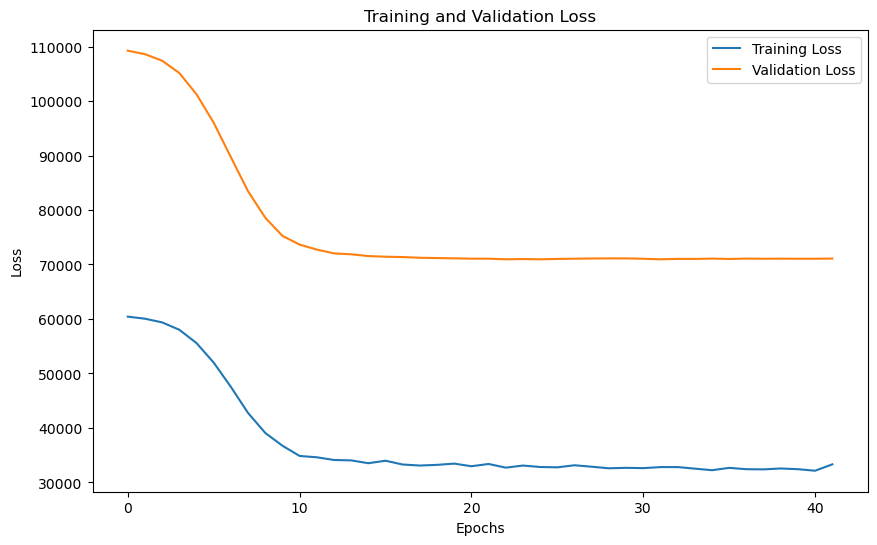

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and evaluate the neural network model
def train_and_evaluate_nn(X_train, X_test, y_train, y_test, epochs=200):
    nn_model = create_nn_model(X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    
    # Evaluate the neural network model
    y_pred_nn = nn_model.predict(X_test)
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    r2_nn = r2_score(y_test, y_pred_nn)
    
    print(f"\nNeural Network Model Performance:")
    print(f"Mean Squared Error: {mse_nn}")
    print(f"R^2 Score: {r2_nn}")
    
    # Plot the training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return nn_model, history

# Run the training and evaluation function
nn_model, history = train_and_evaluate_nn(X_train, X_test, y_train, y_test, epochs=300)  # Adjust the number of epochs as needed


/var/folders/mv/1wspd8ss21x8drphht5pcly80000gn/T/ipykernel_43120/277404838.py:45: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_nn_model, verbose=0)


Starting iteration 1 out of 10...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


2024-05-30 15:59:15.066044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:00:13.772488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.0min


2024-05-30 16:00:15.388616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:01:07.173566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  53.7s


2024-05-30 16:01:09.449382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 1 out of 10 iterations.


/var/folders/mv/1wspd8ss21x8drphht5pcly80000gn/T/ipykernel_43120/277404838.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, iteration_results], ignore_index=True)


Starting iteration 2 out of 10...
Fitting 2 folds for each of 2 candidates, totalling 4 fits


2024-05-30 16:02:42.407039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:03:47.564608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 16:03:50.213953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:04:46.602184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  58.4s


2024-05-30 16:04:48.485519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:06:14.576584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.5min


2024-05-30 16:06:17.328941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:07:38.547751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.4min


2024-05-30 16:07:40.563938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 2 out of 10 iterations.
Starting iteration 3 out of 10...
Fitting 2 folds for each of 3 candidates, totalling 6 fits


2024-05-30 16:10:17.095025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:11:12.515014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  57.0s


2024-05-30 16:11:13.902033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:12:06.271543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  54.1s


2024-05-30 16:12:08.126382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:13:32.121033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.4min


2024-05-30 16:13:33.637847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:14:54.609562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.4min


2024-05-30 16:14:56.228358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:14:56.296500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:15:23.940381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  29.6s


2024-05-30 16:15:25.939660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:15:26.012955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:15:55.590241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  31.1s


2024-05-30 16:15:56.883534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 3 out of 10 iterations.
Starting iteration 4 out of 10...
Fitting 2 folds for each of 4 candidates, totalling 8 fits


2024-05-30 16:17:22.633038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:18:18.785628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  58.6s


2024-05-30 16:18:20.910527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:19:12.192638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  53.2s


2024-05-30 16:19:14.405205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:21:00.831531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.8min


2024-05-30 16:21:04.570689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:22:44.736846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.7min


2024-05-30 16:22:46.848939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:22:46.932138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:23:19.647831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  35.7s


2024-05-30 16:23:22.465551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:23:22.842890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:23:52.986520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  32.7s


2024-05-30 16:23:55.005188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:24:32.278929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  40.5s


2024-05-30 16:24:35.502482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:25:12.117075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  38.6s


2024-05-30 16:25:17.707836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 4 out of 10 iterations.
Starting iteration 5 out of 10...
Fitting 2 folds for each of 5 candidates, totalling 10 fits


2024-05-30 16:27:52.132728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:29:12.974848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.4min


2024-05-30 16:29:15.111447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:30:18.886707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 16:30:21.409507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:31:55.836251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 16:31:58.387588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:33:26.178945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.5min


2024-05-30 16:33:31.587608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:33:31.666859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:34:09.697763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  40.5s


2024-05-30 16:34:12.129424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:34:12.258439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:34:52.363990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  42.4s


2024-05-30 16:34:54.134493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:35:47.976678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  55.6s


2024-05-30 16:35:49.677252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:36:40.299136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  54.6s


2024-05-30 16:36:49.654663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:36:49.713119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:37:44.543169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time= 1.1min


2024-05-30 16:37:47.667351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:37:47.725917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:38:32.497532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  49.6s


2024-05-30 16:38:37.109543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:38:37.180179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


Completed 5 out of 10 iterations.
Starting iteration 6 out of 10...
Fitting 2 folds for each of 6 candidates, totalling 12 fits


2024-05-30 16:39:26.103495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:40:25.139100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.0min


2024-05-30 16:40:27.342223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:41:32.595150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 16:41:35.937591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:43:06.736905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 16:43:11.977554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:44:44.210055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 16:44:47.507966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:44:47.649991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:45:22.010023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  37.1s


2024-05-30 16:45:24.572282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:45:24.739342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:46:01.381686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  39.6s


2024-05-30 16:46:03.987718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:46:45.462058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  44.1s


2024-05-30 16:46:48.206741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:47:38.568506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  52.8s


2024-05-30 16:47:45.484672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:47:45.600577: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:48:42.183324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time= 1.0min


2024-05-30 16:48:43.675279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:48:43.770347: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 16:49:33.884620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  53.9s


2024-05-30 16:49:37.288999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:50:38.728918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 16:50:41.759014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:51:50.712298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.2min


2024-05-30 16:51:54.450525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 6 out of 10 iterations.
Starting iteration 7 out of 10...
Fitting 2 folds for each of 7 candidates, totalling 14 fits


2024-05-30 16:53:48.727473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:54:57.615471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.2min


2024-05-30 16:54:59.291241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:56:02.061260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 16:56:05.592989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:57:49.301791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.8min


2024-05-30 16:57:51.961579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:59:41.013562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.9min


2024-05-30 16:59:44.342355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 16:59:44.420247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:00:28.012775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  49.0s


2024-05-30 17:00:33.271230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:00:33.349510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:01:10.010392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  39.1s


2024-05-30 17:01:12.194234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:01:54.245529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  44.2s


2024-05-30 17:01:56.431239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:02:36.246238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  41.7s


2024-05-30 17:02:41.182457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:02:41.258982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:03:38.624659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time= 1.1min


2024-05-30 17:03:41.353083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:03:41.411751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:04:35.519809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  55.9s


2024-05-30 17:04:37.195701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:05:44.076430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.2min


2024-05-30 17:05:49.818026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:06:54.724108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 17:06:58.040472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:06:58.131753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:07:54.414275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  59.1s


2024-05-30 17:07:57.271390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:07:57.399108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:08:50.278563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  57.6s


2024-05-30 17:08:54.632658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 7 out of 10 iterations.
Starting iteration 8 out of 10...
Fitting 2 folds for each of 8 candidates, totalling 16 fits


2024-05-30 17:10:54.405211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:12:04.618895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.2min


2024-05-30 17:12:06.646033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:13:09.330842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 17:13:11.905723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:14:56.200905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.8min


2024-05-30 17:15:00.861875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:17:15.103375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 2.3min


2024-05-30 17:17:19.223005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:17:19.334713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:18:13.167897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  58.7s


2024-05-30 17:18:18.020912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:18:18.174021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:19:02.348110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  46.7s


2024-05-30 17:19:04.403909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:19:56.734123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  55.5s


2024-05-30 17:19:59.656984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:20:40.038113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  42.8s


2024-05-30 17:20:48.175615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:20:48.256749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:21:37.382159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  58.1s


2024-05-30 17:21:40.744587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:21:40.828847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:22:25.365810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  47.0s


2024-05-30 17:22:27.676046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:23:29.928452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 17:23:32.252110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:24:33.417441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 17:24:36.615644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:24:36.686168: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:25:26.297603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  52.2s


2024-05-30 17:25:29.027652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:25:29.113787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:26:17.641603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  52.3s


2024-05-30 17:26:20.809569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:27:04.142409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time=  45.4s


2024-05-30 17:27:06.109876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:27:50.285421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time=  46.2s


2024-05-30 17:27:52.279029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 8 out of 10 iterations.
Starting iteration 9 out of 10...
Fitting 2 folds for each of 9 candidates, totalling 18 fits


2024-05-30 17:30:35.801381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:31:33.934244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time= 1.0min


2024-05-30 17:31:35.747999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:32:32.410372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  58.6s


2024-05-30 17:32:34.322469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:34:06.130622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 17:34:08.270004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:35:41.869160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 17:35:44.338975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:35:44.470354: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:36:23.042997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  40.8s


2024-05-30 17:36:25.071105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:36:25.141334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:36:59.474902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  36.5s


2024-05-30 17:37:01.352664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:37:44.560145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  45.0s


2024-05-30 17:37:46.349896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:38:23.640326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  39.1s


2024-05-30 17:38:28.983798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:38:29.063710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:39:19.296092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  55.8s


2024-05-30 17:39:21.505363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:39:21.571462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:40:04.074150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  44.7s


2024-05-30 17:40:05.967604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:41:03.597064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.0min


2024-05-30 17:41:06.572615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:42:05.553671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.0min


2024-05-30 17:42:08.328215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:42:08.395644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:42:59.228456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  53.3s


2024-05-30 17:43:01.580292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:43:01.644378: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:43:47.330073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  48.2s


2024-05-30 17:43:49.934507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:44:26.345078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time=  40.2s


2024-05-30 17:44:29.961009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:45:08.564386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time=  41.2s


2024-05-30 17:45:11.244879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:45:11.310332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:46:29.986819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=32, optimizer=adam; total time= 1.3min


2024-05-30 17:46:36.586557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:46:36.684609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:47:57.273149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=32, optimizer=adam; total time= 1.5min


2024-05-30 17:47:59.771873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 9 out of 10 iterations.
Starting iteration 10 out of 10...
Fitting 2 folds for each of 10 candidates, totalling 20 fits


2024-05-30 17:49:37.853137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:50:35.723858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  59.8s


2024-05-30 17:50:37.598932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:51:33.396255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=32, optimizer=rmsprop; total time=  58.2s


2024-05-30 17:51:36.139785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:53:11.640345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 17:53:13.788348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:54:49.914872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=64, optimizer=rmsprop; total time= 1.6min


2024-05-30 17:54:52.515901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:54:52.593943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:55:35.920488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  45.4s


2024-05-30 17:55:38.560304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:55:38.637233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:56:22.596272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  47.0s


2024-05-30 17:56:24.980769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:57:11.008980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  48.1s


2024-05-30 17:57:12.902424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:57:54.977371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.2, epochs=50, neurons=32, optimizer=rmsprop; total time=  44.3s


2024-05-30 17:58:01.500640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:58:01.594082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:58:52.319201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  57.5s


2024-05-30 17:58:54.966266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 17:58:55.055675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 17:59:42.751855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=adam; total time=  51.0s


2024-05-30 17:59:45.617189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:00:45.984485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.0min


2024-05-30 18:00:48.066697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:01:53.218821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time= 1.1min


2024-05-30 18:01:55.544824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:01:55.610606: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 18:02:41.728976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  48.1s


2024-05-30 18:02:43.562535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:02:43.626086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 18:03:31.209511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=100, neurons=64, optimizer=adam; total time=  50.5s


2024-05-30 18:03:34.220614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:04:24.023344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time=  52.4s


2024-05-30 18:04:26.476620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:05:14.798799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=32, dropout_rate=0.3, epochs=50, neurons=32, optimizer=rmsprop; total time=  50.2s


2024-05-30 18:05:20.499091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:05:20.563798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 18:06:42.176875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=32, optimizer=adam; total time= 1.5min


2024-05-30 18:06:44.953789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:06:45.056903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 18:07:59.451890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.3, epochs=100, neurons=32, optimizer=adam; total time= 1.3min


2024-05-30 18:08:01.440527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:08:01.503589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 18:08:47.448150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.2, epochs=50, neurons=32, optimizer=adam; total time=  48.4s


2024-05-30 18:08:50.059365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:08:50.146745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-05-30 18:09:36.731467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END batch_size=16, dropout_rate=0.2, epochs=50, neurons=32, optimizer=adam; total time=  49.6s


2024-05-30 18:09:39.460775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Completed 10 out of 10 iterations.
Best: -40552.312555169614 using {'optimizer': 'rmsprop', 'neurons': 32, 'epochs': 100, 'dropout_rate': 0.3, 'batch_size': 32}
-40552.312555169614 (1704.5186370420597) with: {'optimizer': 'rmsprop', 'neurons': 32, 'epochs': 100, 'dropout_rate': 0.3, 'batch_size': 32}
-40700.01236209145 (1472.1371595802448) with: {'optimizer': 'rmsprop', 'neurons': 64, 'epochs': 100, 'dropout_rate': 0.3, 'batch_size': 16}
-40952.48122938871 (1380.5610437938012) with: {'optimizer': 'adam', 'neurons': 32, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 32}
-41199.7545855623 (2294.2093659822785) with: {'optimizer': 'rmsprop', 'neurons': 32, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 32}
-40823.52968956806 (1420.454280372447) with: {'optimizer': 'adam', 'neurons': 32, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 16}
-40717.815286573656 (1722.5489490450273) with: {'optimizer': 'rmsprop', 'neurons': 32, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 16}
-41100.54

2024-05-30 18:11:14.976908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 96ms/step

Best Model Performance on Test Set:
Mean Squared Error: 29349.61591219673
R^2 Score: 0.13072691402885706


2024-05-30 18:11:17.604131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-30 18:11:37.150087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


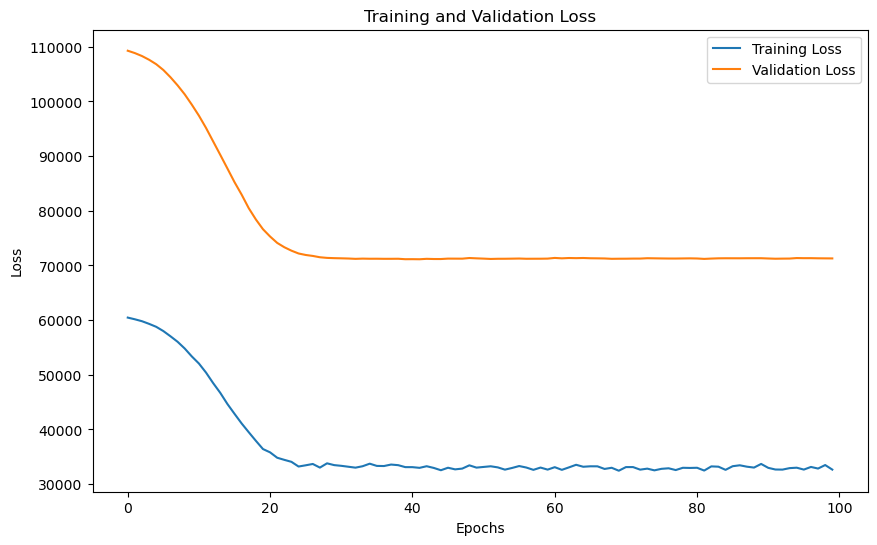

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import gc
import tensorflow as tf
import pandas as pd

# Define the neural network model
def create_nn_model(optimizer='adam', dropout_rate=0.2, neurons=32):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Custom callback to print progress
class PrintProgress:
    def __init__(self, total):
        self.total = total
        self.current = 0

    def __call__(self):
        self.current += 1
        print(f"Completed {self.current} out of {self.total} iterations.")

# Define the random search parameters
param_distributions = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3],
    'neurons': [32, 64]
}

# Total number of iterations
n_iter = 10

# Create RandomizedSearchCV
model = KerasRegressor(build_fn=create_nn_model, verbose=0)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=n_iter, scoring='neg_mean_squared_error', cv=2, verbose=2, random_state=42)

# Create a PrintProgress callback instance
progress_logger = PrintProgress(total=n_iter)

# File to save results
results_file = "hyperparameter_tuning_results.csv"

# Initialize results dataframe
results_df = pd.DataFrame(columns=["iteration", "mean_test_score", "std_test_score", "params"])

# Fit RandomizedSearchCV with progress logging and memory clearing
for i in range(n_iter):
    print(f"Starting iteration {i+1} out of {n_iter}...")
    random_search.n_iter = i + 1
    random_search_result = random_search.fit(X_train, y_train)
    progress_logger()
    
    # Clear memory
    gc.collect()
    tf.keras.backend.clear_session()
    
    # Save iteration results
    iteration_results = pd.DataFrame([{
        "iteration": i + 1,
        "mean_test_score": random_search_result.best_score_,
        "std_test_score": random_search_result.cv_results_['std_test_score'][random_search_result.best_index_],
        "params": random_search_result.best_params_
    }])
    results_df = pd.concat([results_df, iteration_results], ignore_index=True)
    results_df.to_csv(results_file, index=False)

# Summarize results
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")
means = random_search_result.cv_results_['mean_test_score']
stds = random_search_result.cv_results_['std_test_score']
params = random_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

# Evaluate the best model on the test set
best_model = random_search_result.best_estimator_.model
y_pred_nn = best_model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\nBest Model Performance on Test Set:")
print(f"Mean Squared Error: {mse_nn}")
print(f"R^2 Score: {r2_nn}")

# Retrain the best model to get the history
best_params = random_search_result.best_params_
best_model = create_nn_model(optimizer=best_params['optimizer'], dropout_rate=best_params['dropout_rate'], neurons=best_params['neurons'])
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2, verbose=0)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
